Assignment 4: Survival Analysis

AI was used to error correct and clarify concepts

In [100]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance


In [66]:
#Load Data
clin_data = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx', sheet_name='RADCURE_Data')

Data Cleaning

In [67]:
data = clin_data.copy()
#Data Cleaning
 # data cleaning
 #Drop unnecessary columns
data = data.drop(columns=['RADCURE-challenge', 'ContrastEnhanced'])
data = data.loc[:, data.isnull().mean() < 0.25].copy() 
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns


# Fill missing values
# For numerical columns, fill with mean; for categorical columns, fill with mode
for col in numerical_cols:
       
    data[col] = data[col].fillna(data[col].mean()) 
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Convert the target variable to a structured array for survival analysis

# Convert event column to boolean (Death = True, Alive = False)
data["event"] = data["Status"].apply(lambda x: True if x == "Dead" else False)

#Create time column
data["RT Start"] = pd.to_datetime(data["RT Start"])
data["Last FU"] = pd.to_datetime(data["Last FU"])
data["time"] = data["Last FU"] - data["RT Start"]
data['time'] = data['time'] / pd.Timedelta(days=1)

# Convert to structured array for survival analysis
survival_data = Surv.from_dataframe("event", "time", data)
data.head()

,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Tx Modality,Chemo,RT Start,Dose,Fx,Last FU,Status,Length FU,event,time
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,RT alone,none,2002-02-20,60.0,25,2003-05-12,Dead,1.317808,True,446.0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,RT alone,none,2006-01-17,51.0,20,2007-06-28,Dead,1.520548,True,527.0
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,RT alone,none,2009-11-09,64.0,40,2011-12-05,Alive,2.126027,False,756.0
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,Glottis,T0,N2c,...,RT alone,none,2002-10-07,70.0,35,2008-05-27,Alive,5.791781,False,2059.0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,RT alone,none,2000-12-19,64.0,40,2010-05-25,Alive,9.512329,False,3444.0


In [85]:
print(categorical_cols)

Index(['patient_id', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status',
       'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'Tx Modality',
       'Chemo', 'Status'],
      dtype='object')


Part 1: Kaplan-Meler Analysis
#Groups will be stratified by smoking status

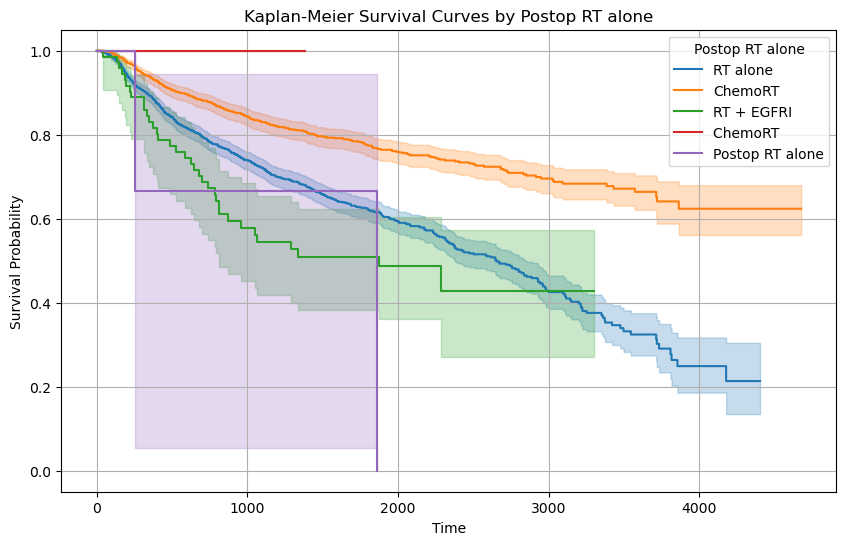

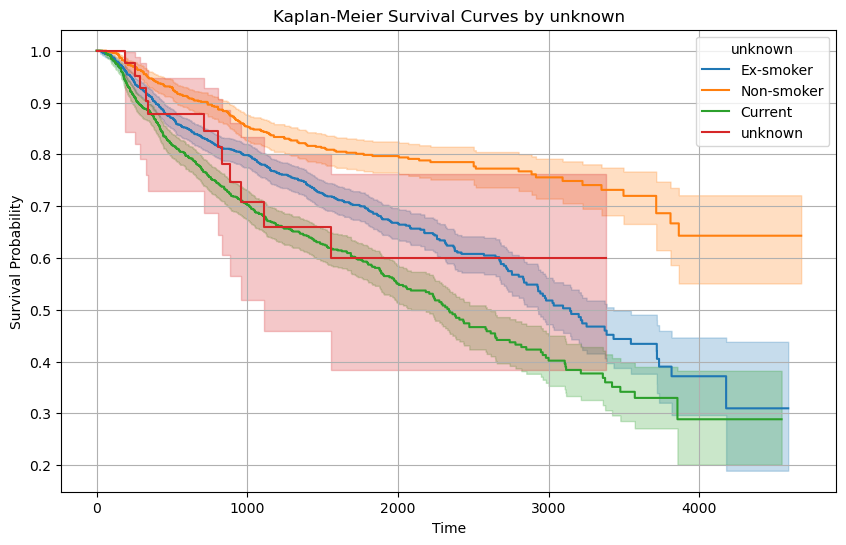

In [68]:
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for group in data['Tx Modality'].unique():
    tx_data =  data[data['Tx Modality'] == group]
    kmf.fit(tx_data['time'], tx_data['event'], label=group)
    kmf.plot_survival_function(ci_show=True)
    
plt.title(f'Kaplan-Meier Survival Curves by {group}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title=group)
plt.show()

#compare to smoking status
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for group in data['Smoking Status'].unique():
    smoke_data =  data[data['Smoking Status'] == group]
    kmf.fit(smoke_data['time'], smoke_data['event'], label=group)
    kmf.plot_survival_function(ci_show=True)
    
plt.title(f'Kaplan-Meier Survival Curves by {group}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title=group)

In [98]:
#for logs rank test

#For Treatment Modality
from lifelines.statistics import multivariate_logrank_test
results = multivariate_logrank_test(data['time'], data['Tx Modality'], data['event'])
print(results.summary)

#for Smoking Status
results = multivariate_logrank_test(data['time'], data['Smoking Status'], data['event'])
print(results.summary)

   test_statistic             p   -log2(p)
0      132.659989  1.050650e-27  89.620777
   test_statistic             p  -log2(p)
0      128.079815  1.402342e-27  89.20422


Part 2: Cox Regression

Index(['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status',
       'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'Tx Modality',
       'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status', 'Length FU',
       'event', 'time'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7780.00
         time fit was run = 2025-07-15 03:36:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sex         0.02       1.02       0.08            -0.13             0.17                 0.88                 1.19
ECOG PS     0.21       1.24       0.02             0.18             0.24                 1.20                 1.27
Age         0.04       1.04       0.00             0.03             0.05                 1.04                 1.05

            cmp to     z      p   -log2(p)
covariate                                 
Sex           0.00  0.32   0.75       0.41
ECOG PS       0.00 13.77 <0.005     140.96
Age           0.00 14.14 <0.005     148.32
---
Concordance = 0.67
Partial AIC = 15566.01
log-likelihood ratio test = 387.82 on 3 df
-log2(p) of ll-ratio test = 275.78

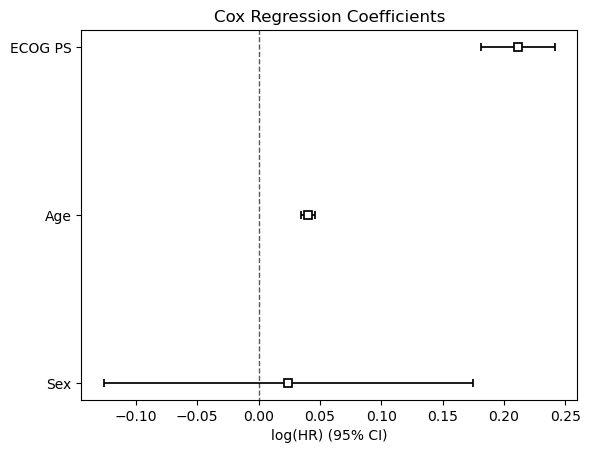

AttributeError: CoxPHFitter has no attribute 'predict_partial'

In [ ]:

#Encode one-hot Categorical Variables
#data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


cph = CoxPHFitter()

# set the covariates for the model
print(data.columns)

covariates = ['Sex', 'ECOG PS', 'Age' ]
for col in covariates:
    if data[col].dtype == 'object' or data[col].dtype.name == 'category':
        data[col] = data[col].astype("category").cat.codes
# Fit the Cox Proportional Hazards model
cph.fit(data[["time", "event"] + covariates], duration_col="time", event_col="event")


cph.print_summary()
cph.plot()
plt.title('Cox Regression Coefficients')
plt.show()

#Check the proportional hazards assumption  

# This will check the proportional hazards assumption for the Cox model 
cph.check_assumptions(data, p_value_threshold=0.05)
#Calculate concordance index
c_index = concordance_index_censored(data['event'], data['time'], cph.predict_partial(data[covariates]))
print(f'Concordance Index: {c_index[0]}')

Random Forest

In [1]:

# Split the data into training and testing sets
encoder = OneHotEncoder()
# Encode categorical variables
data[covariates] = data[covariates].astype('category')
data_encoded = encoder.fit_transform(data[covariates])
data_encoded_names = encoder.get_feature_names_out(input_features=covariates)
data_encoded = pd.DataFrame(data_encoded, columns=data_encoded_names,index=data.index)
X = data_encoded

# Drop any columns with non-numeric types (e.g., datetime64)
X = X.select_dtypes(include=[np.number])

# Ensure the survival data is in the correct format  
Y = survival_data    
#Train Random Survival Forest

#run with n_estimators=5 due to computational constraints
rsf = RandomSurvivalForest(n_estimators=5, min_samples_split=10, min_samples_leaf=5, random_state=42,n_jobs=-1)
rsf.fit(X, Y)

# Evaluate the model
result = permutation_importance(rsf, X, Y, n_repeats=15, random_state=42)
feature_importance = pd.DataFrame(
         {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X.columns,
).sort_values(by="importances_mean", ascending=False)

# Sort by importances_mean and plot
feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()        

NameError: name 'OneHotEncoder' is not defined

In [ ]:
#Calculate concordance index for Random Survival Forest
c_index_rsf = rsf.score(X, Y)   

For entire dataset

Not enough computational power to preform

In [106]:
encoder = OneHotEncoder()
# Encode categorical variables
data[categorical_cols] = data[categorical_cols].astype('category')
data_encoded = encoder.fit_transform(data[categorical_cols])
data_encoded_names = encoder.get_feature_names_out(input_features=categorical_cols)
data_encoded = pd.DataFrame(data_encoded, columns=data_encoded_names,index=data.index)
# Combine encoded data with survival data
df_encoded = pd.concat([data.drop(columns=categorical_cols), data_encoded],axis=1)
# Split the data into training and testing sets
X = df_encoded.drop(columns=['event', 'time'])

# Drop any columns with non-numeric types (e.g., datetime64)
X = X.select_dtypes(include=[np.number])

# Ensure the survival data is in the correct format  
Y = survival_data    
#Train Random Survival Forest

#run with n_estimators=5 due to computational constraints
rsf = RandomSurvivalForest(n_estimators=5, min_samples_split=10, min_samples_leaf=5, random_state=42,n_jobs=-1)
rsf.fit(X, Y)

# Evaluate the model
result = permutation_importance(rsf, X, Y, n_repeats=15, random_state=42)
feature_importance = pd.DataFrame(
         {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X.columns,
).sort_values(by="importances_mean", ascending=False)

# Sort by importances_mean and plot
feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()        

KeyboardInterrupt: 